# Clustering-Based Estimation of 10-Day 99% VaR for the S&P 500

## Introduction
This project applies Hierarchical Clustering to identify distinct market regimes based on the statistical properties of S&P 500 stock returns. To model the risk of each regime, this analysis uses Gaussian copulas to capture the dependence structure of returns.

## Goal
* To segment the time series of S&P 500 returns into distinct clusters, where each cluster represents a specific market regime (e.g., high volatility, low volatility).
* To model the risk of each regime by fitting probability distributions and using a Gaussian Copula to simulate and calculate the 10-day 99% Value at Risk (VaR).

## Project Structure
The project follows a pipeline structure:
1. **Feature Engineering:** Calculating rolling statistical moments (mean, volatility, skewness, kurtosis) from lagged S&P 500 returns.
2. **Clustering:** Applying Agglomerative Hierarchical Clustering to the engineered features to identify market regimes.
3. **Risk Modeling & Analysis:** Fitting unique statistical distributions to each cluster's returns, modeling their dependence with a copula, and running a Monte Carlo simulation to determine the VaR for each regime.

## Model
### Clustering Model
* **Algorithm:** Agglomerative Hierarchical Clustering.
* **Linkage Method:** 'ward', which minimizes the variance of the clusters being merged.
* **Features:** The model is trained on scaled rolling statistical moments of returns, not the returns themselves.
* **Cluster Determination:** the number of clusters is determined by setting a distance_threshold of '125.0', a value chosen based on the dendrogram.

### Risk Model
* **Marginal Distributions:** The returns within each cluster are modeled using different probability distributions from 'scipy' module to capture their unique shapes.
* **Dependence Structure:** A Gaussian Copula is fitted to the returns of each cluster to model the joint probability distribution and capture the correlation structure between lagged returns.

## Performance Measures
As this is an unsupervised learning project, traditional performance metrics like accuracy are not applicable. The VaR backtesting was also omitted. The model's performance is evaluated through:
* **Dendrogram Analysis:** To visually assess the cluster separation and justify the chosen distance threshold.
* **Visual Goodness-of-Fit:** Plotting the Kernel Density Estimate (KDE) of the empirical returns against the Probability Density Function (PDF) of the fitted distributions for each cluster.
* **Value at Risk (VaR):** The final output is the 10-day 99% VaR for each cluster, which serves as a quantitative measure of the risk associated with each identified market state.

## Input Data Specification
Location:
* The US Market;

Time Horizon:
* 10 years (2012-12-21, 2022-12-20);

Price Frequency:
* Daily;

Returns:
* Arithmetic;

## Data Sources
* https://finance.yahoo.com/

## Results

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import (
    skewnorm, t,
    jf_skew_t, norm, multivariate_normal
    )

In [3]:
# constants
DATA_PATH = 'data/hierarcical_clustering_data.csv'
DATE_COLUMN = 'Date'
TICKER = '^GSPC'
MAX_LAG = 9
WINDOW = 20
SAMPLE_SIZE = 1000
SEED = 21

In [4]:
# adding missing functionality used to fit Gaussian copulas
def fit_distributions(data, target_cols, cluster_col, dist_mapper):
    dist_fitted = {}

    for cluster in sorted(data[cluster_col].unique()):
        if str(cluster) not in dist_mapper:
            raise KeyError(f"No distribution mapping for cluster '{cluster}'.")

        dist  = dist_mapper[str(cluster)]
        cluster_data = data[data[cluster_col] == cluster]

        fitted = {
            col: MarginalDist(dist, dist.fit(cluster_data[col]))
            for col in target_cols
        }

        dist_fitted[cluster] = fitted

    return dist_fitted

def fit_copulas(data, target_cols, cluster_col, fitted_dist):
    copulas_fitted = {}

    for cluster in sorted(data[cluster_col].unique()):
        if cluster not in fitted_dist:
            raise KeyError(f"No fitted distributions for cluster '{cluster}'.")

        container = fitted_dist[cluster]
        cluster_data = data[data[cluster_col] == cluster][target_cols]

        copula = GaussianCopula(container)
        copula.fit(cluster_data)

        copulas_fitted[cluster] = copula

    return copulas_fitted

def sample_10d_returns(fitted_copulas, size, seed):
    returns_10d = {}

    for cluster, copula in fitted_copulas.items():
        returns_1d = copula.sample(size, seed=seed)
        returns_1d = returns_1d + 1
        returns_10d[cluster] = returns_1d.prod(axis=1) - 1
    
    return returns_10d

def get_var_values(mapper, cl=0.99, interpolation='linear'):
    var_values = []

    for cluster, returns in mapper.items():
        var_value = returns.quantile(q=(1-cl), interpolation=interpolation)
        var_values.append((cluster, var_value))
    
    var_values = pd.DataFrame(
        var_values, columns=['cluster', f'var_{int(cl*100)}']
        )

    return var_values

class MarginalDist:
    def __init__(self, dist, params, name=None):
        self._dist = dist
        self._params = params
        self.name = name or dist.__class__.__name__

    def pdf(self, x):
         return self._dist.pdf(x, *self._params)

    def cdf(self, x):
        return self._dist.cdf(x, *self._params)

    def ppf(self, q):
        return self._dist.ppf(q, *self._params)

    def __repr__(self):
        return f"MarginalDist(name={self.name}, dist={self._dist}, params={self._params})"


class GaussianCopula:
    def __init__(self, container):
        self._container = container

    def fit(self, data):
        self._fit_marginals(data)
        self._fit_dependence()

    def _fit_marginals(self, data):
        uniform = {
            col: np.clip(self._container[col].cdf(data[col]), 1e-10, 1 - 1e-10)
            for col in self._container
        }
        self._uniform = pd.DataFrame(uniform)

    def _fit_dependence(self):
        self._standard_normal = pd.DataFrame(
            norm.ppf(self._uniform),
            columns=self._uniform.columns
        )
        self._mean = self._standard_normal.mean().to_numpy()
        self._cov_matrix = self._standard_normal.cov().to_numpy()

    def sample(self, size, seed=None):
        samples = multivariate_normal.rvs(
            mean=self._mean,
            cov=self._cov_matrix,
            size=size,
            random_state=seed
        )

        if size == 1:
            samples = samples.reshape(1, -1)

        std_norm_df = pd.DataFrame(samples, columns=self._container.keys())

        uniform_samples = pd.DataFrame(
            norm.cdf(std_norm_df).clip(1e-10, 1 - 1e-10),
            columns=std_norm_df.columns,
            index=std_norm_df.index
        )

        out = {
            col: self._container[col].ppf(uniform_samples[col])
            for col in self._container
        }

        return pd.DataFrame(out, columns=self._container.keys())

In [5]:
# loading data
data = pd.read_csv(DATA_PATH, usecols=[DATE_COLUMN, TICKER], index_col=0)
data = data.rename({TICKER:'r_0'}, axis=1)

In [6]:
# lagging returns
for lag in range(1, MAX_LAG + 1):
    data[f'r_{lag}'] = data['r_0'].shift(lag)
data = data.dropna()

# calculating rolling means
for lag in range(0, MAX_LAG + 1):
    data[f'mu_{lag}'] = data[f'r_{lag}'].rolling(WINDOW).mean()

# calculating rolling volatility
for lag in range(0, MAX_LAG + 1):
    data[f'vol_{lag}'] = data[f'r_{lag}'].rolling(WINDOW).std()

# calculating rolling skewness
for lag in range(0, MAX_LAG + 1):
    data[f'skew_{lag}'] = data[f'r_{lag}'].rolling(WINDOW).skew()

# calculating rolling kurtosis
for lag in range(1, MAX_LAG + 1):
    data[f'kurt_{lag}'] = data[f'r_{lag}'].rolling(WINDOW).kurt()

# dropping nas 
data = data.dropna()

# scaling data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

# preparing the data for clustering
mask = ~data_scaled.columns.str.startswith('r_')
columns_to_keep = data_scaled.columns[mask]
data_clustering = data_scaled[columns_to_keep]


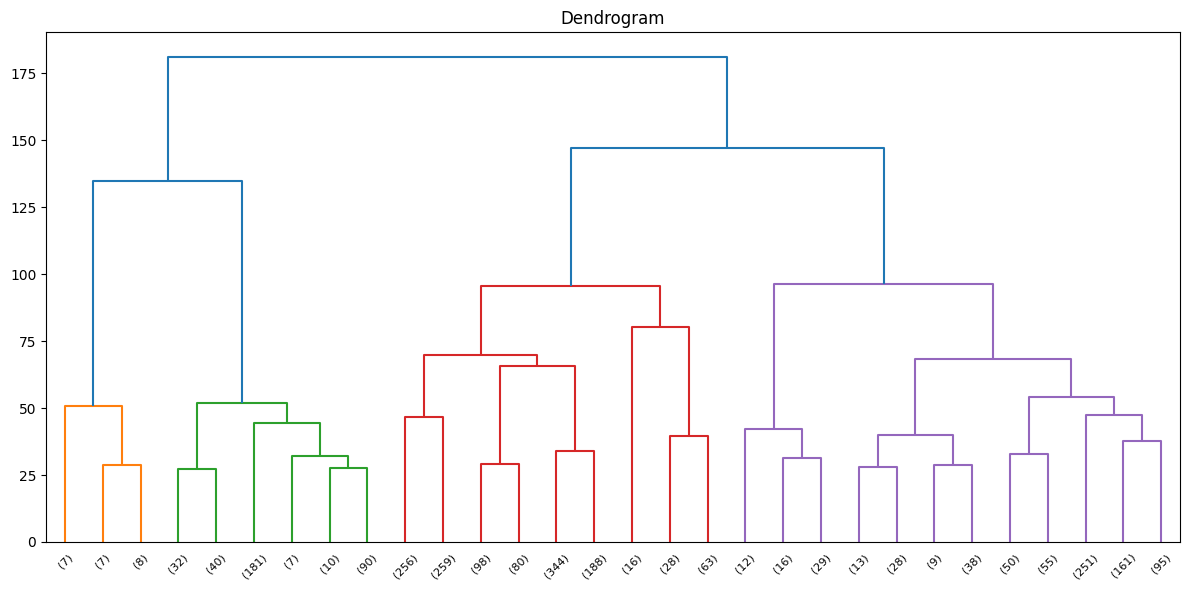

In [7]:
# computing linkage matrix
linkage_matrix = linkage(data_clustering, method='ward')

# plotting dendrogram
plt.figure(figsize=(12, 6))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp', 
    leaf_font_size=8
    )
plt.title('Dendrogram')
plt.tight_layout()
plt.show()

In [8]:
# computing clusters 
model = AgglomerativeClustering(
    linkage='ward',
    metric='euclidean',
    distance_threshold=125.0,
    n_clusters=None
)
data['cluster'] = model.fit_predict(data_clustering)
data['cluster'] = data['cluster'].astype(str)

In [9]:
# printing cluster weights
pd.set_option('display.float_format', '{:.2%}'.format)
cluster_weights = data['cluster'].value_counts() / len(data)
cluster_weights = cluster_weights.sort_index()
cluster_weights

cluster
0   30.64%
1   14.57%
2   53.91%
3    0.89%
Name: count, dtype: float64

In [10]:
# fitting distributions
mask = data.columns.str.startswith('r_')
lags = data.columns[mask]
mapper = {
    '0' : jf_skew_t,
    '1' : skewnorm,
    '2' : jf_skew_t,
    '3' : t
}

dist_fitted = fit_distributions(data, lags, 'cluster', mapper)
copulas_fitted = fit_copulas(data, lags, 'cluster', dist_fitted)

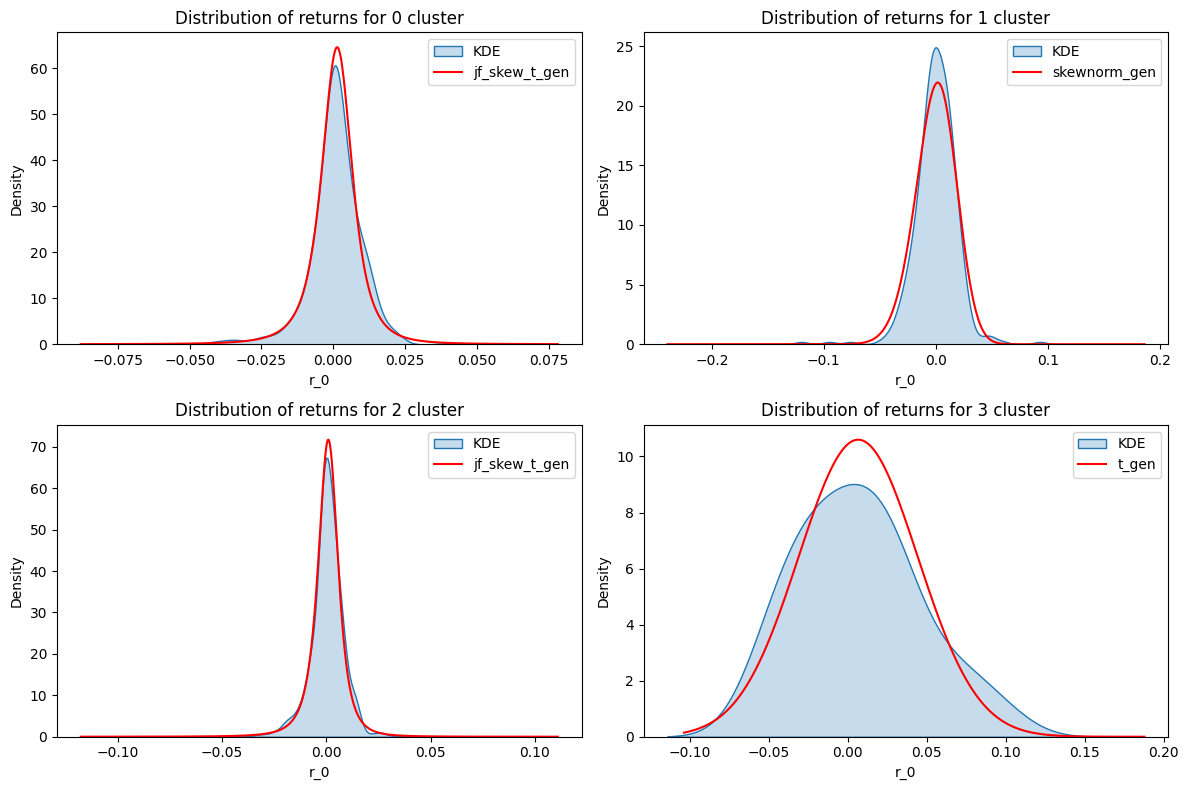

In [25]:
# plotting distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, cluster in enumerate(sorted(dist_fitted.keys())):
    returns = data[data['cluster'] == cluster]['r_0']
    dist = dist_fitted[cluster]['r_0']
    
    x = np.linspace(2 * min(returns), 2 * max(returns), 1000)
    pdf = dist.pdf(x)

    sns.kdeplot(returns, ax=axes[i], label='KDE', fill=True)
    axes[i].plot(x, pdf, label=dist.name, color='red')
    axes[i].set_title(f'Distribution of returns for {cluster} cluster')
    axes[i].legend()

plt.tight_layout()
plt.show()  

In [12]:
# simulating returns and estimating VaR values
returns_10d = sample_10d_returns(copulas_fitted, SAMPLE_SIZE, SEED)
var_values = get_var_values(returns_10d)

In [13]:
# printing obtained values
pd.set_option('display.float_format', '{:.2%}'.format)
var_values

,cluster,var_99
0,0,-9.69%
1,1,-9.98%
2,2,-4.58%
3,3,-27.28%


In [14]:
# calculating the weighted average of results
weighter_average_var = np.sum(var_values["var_99"].to_numpy() * cluster_weights.to_numpy())
print(f"Weighted Average Simulated 10-day 99% VaR: {weighter_average_var:.2%}")

Weighted Average Simulated 10-day 99% VaR: -7.13%


In [15]:
# estimating the historical 10-day 99% VaR
returns_hist = data[data.columns[mask]]
returns_hist_10d = (returns_hist + 1).prod(axis=1) - 1
var_hist_10d = returns_hist_10d.quantile(q=(1 - 0.99), interpolation="linear")

print(f"Historical 10-day 99% VaR: {var_hist_10d:.2%}")

Historical 10-day 99% VaR: -9.26%


# Conclusions

The analysis successfully identified four distinct market regimes from the S&P 500 data, each with a different frequency of occurrence. The risk modeling showed a clear differentiation in the risk profiles of these regimes, quantified by the 10-day 99% VaR:
* **Cluster 0:** -9.69% VaR;
* **Cluster 1:** -9.98% VaR;
* **Cluster 2:** -4.58% VaR;
* **Cluster 3:** -27.28%% Var;

By weighting the individual regime VaR results by their respective frequencies of occurrence, the simulated weighted average 10-day 99% VaR for the S&P 500 is -7.13%. The result is lower than the historical -9.26% VaR.